# Photometry with XGA

This tutorial will show you how to perform basic photometric analyses on XGA sources, starting with how you use the built in SAS interface to generate the necessary XMM images, exposure maps, and the XGA ratemap objects. Using the SAS interface requires that a version of SAS be installed on your system, and the module will check for the presence of this software before trying to run any SAS routines.

I will take you through the basics of interacting with the XGA photometric products, including using source masks and the built in peak finding techniques. 

In [17]:
from astropy.units import Quantity
import numpy as np
import pandas as pd

from xga.sources import GalaxyCluster
from xga.samples import ClusterSample
from xga.sas import evselect_image, eexpmap, emosaic
from xga.utils import xmm_sky

First of all, I will declare an individual galaxy cluster source object, and a galaxy cluster sample object. I am going to demonstrate that you can use the SAS interface with individual sources and samples of sources in exactly the same way.  The sample of four clusters is taken from the XCS-SDSS sample (**add reference to Paul's paper**), and the individual cluster is Abell 907. 

In [2]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']
cluster_data = np.array([['XCSSDSS-124', 0.80057775, -6.0918182, 0.251, 1220.11, 1777.06, 109.55, 4.49],
                         ['XCSSDSS-2789', 0.95553986, 2.068019, 0.11, 1039.14, 1519.79, 38.90, 2.83],
                         ['XCSSDSS-290', 2.7226392, 29.161021, 0.338, 935.58, 1359.37, 105.10, 5.99],
                         ['XCSSDSS-134', 4.9083898, 3.6098177, 0.273, 1157.04, 1684.15, 108.60, 4.79]])

# Possibly I'm overcomplicating this by making it into a dataframe, but it is an excellent data structure,
#  and one that is very commonly used in my own analyses.
sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']].astype(float)

# Defining the sample of four XCS-SDSS galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values, r200=Quantity(sample_df["r200"].values, "kpc"),
                         r500=Quantity(sample_df["r500"].values, 'kpc'), richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values)

# And defining an individual source object for Abell 907
demo_src = GalaxyCluster(149.59209, -11.05972, 0.16, r500=Quantity(1200, 'kpc'), r200=Quantity(1700, 'kpc'), 
                         name="A907")

Setting up Galaxy Clusters:   0%|          | 0/4 [00:00<?, ?it/s]

Pre-generating necessary products


Setting up Galaxy Clusters:  25%|██▌       | 1/4 [00:01<00:04,  1.34s/it]/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Setting up Galaxy Clusters: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


## A note on XGA's Parallelism

In every SAS function built into XGA (and indeed many functions in other parts of the module), you will find a **num_cores** keyword argument which tells the function how many cores on your local machine it is allowed to use. The default value is 90% of the available cores on your system, though you are of course free to set your own value when you call the functions.

XGA does not currently support parallelism through job submission to HPCs, though that is a planned feature.

To see the number of cores which have automatically allocated to XGA, you can import the NUM_CORES constant from the base xga module (this tutorial for instance was run on a laptop with an Intel Core i5-8300H CPU, with four physical cores and four logical cores):

In [3]:
from xga import NUM_CORES
NUM_CORES

7

## Generating XMM Images with XGA

Please note that the XCS data reduction pipeline produces images and exposure maps in the 0.5-2.0keV and 2.0-10.0keV energy ranges, and as the configuration file points XGA towards existing data, these sources will already have those images and exposure maps loaded in.

Please also note that ClusterSample class automatically generates images and exposure maps in the energy range used for peak finding (set by the keyword arguments **peak_lo_en** and **peak_hi_en**, by default 0.5keV and 2.0keV respectively). An individual GalaxyCluster source object will also automatically generate images and exposure maps in this range, but only if the **use_peak** keyword argument is set to True (which it is by default).

As such, I'm going to demonstrate how you can generate images and exposure maps in another (probably not very useful in a real analysis) energy range, 0.5-2.0keV. When telling SAS what energy range to generate in, we use Astropy quantities in units of keV, though you could supply limits in any energy unit:

In [4]:
# Setting up the lower and upper energy bounds for our products
lo_en = Quantity(0.5, 'keV')
hi_en = Quantity(10.0, 'keV')

In [5]:
# This will generate images in the 0.5-10keV range, for every instrument in 
#  every ObsID in every source in this sample
demo_smp = evselect_image(demo_smp, lo_en=lo_en, hi_en=hi_en)

# The function call is identical when generating images for an individual source, but here 
#  I have limited XGA to using only four cores
demo_src = evselect_image(demo_src, lo_en=lo_en, hi_en=hi_en, num_cores=4)

These images have now been generated and associated with the appropriate source.

## Generating XMM Exposure Maps with XGA

The process for generating exposure maps is almost identical to the image generation process, we simply call a different function, though XMM calibration files (CCFs) are required to make exposure maps, so they will be generated if they do not already exist:

In [6]:
# This will generate expmaps in the 0.5-10keV range, for every instrument in 
#  every ObsID in every source in this sample
demo_smp = eexpmap(demo_smp, lo_en=lo_en, hi_en=hi_en)

# The function call is identical when generating expmaps for an individual source
demo_src = eexpmap(demo_src, lo_en=lo_en, hi_en=hi_en)

## XGA Ratemaps

Now that we've generated images and exposure maps for our weird, custom energy range, we can see that XGA has automatically made RateMaps from those products, I use the individual source as a demonstration here. There are nine ratemaps present because there are three observations of Abell 907, each with three valid instruments:

In [7]:
rts = demo_src.get_products('ratemap', extra_key='bound_0.5-10.0')
rts

## Basic properties of ANY XGA Product

Here I just demonstrate some of the most basic (but still useful) properties of XGA's photometric products. I am going to use one of the ratemaps generated for Abell 907, but the properties I demonstrate in this section will be present in **any** XGA photometric product. These first properties should actually be present in every XGA product, photometric or otherwise:

In [8]:
chosen_ratemap = rts[0]

# If generated using XGA's SAS interface, the product stores the name 
#  of the source it is associated with
print(chosen_ratemap.src_name, '\n')

# Its also aware of what ObsID and instrument it is from
print(chosen_ratemap.obs_id, chosen_ratemap.instrument, '\n')

# And where the base file is stored 
print(chosen_ratemap.path)

A907 

0404910601 pn 

/home/dt237/code/PycharmProjects/XGA/docs/source/notebooks/tutorials/xga_output/0404910601/0404910601_pn_0.5-10.0keVimg.fits


In [9]:
print('DELETE THIS')
dir(chosen_ratemap)

DELETE THIS


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_construct_on_demand',
 '_data',
 '_edge_mask',
 '_energy_bounds',
 '_ex_data',
 '_ex_obj',
 '_expmap_path',
 '_header',
 '_im_data',
 '_im_obj',
 '_im_path',
 '_inst',
 '_obs_id',
 '_og_cmd',
 '_on_sensor_mask',
 '_other_error',
 '_path',
 '_prod_type',
 '_psf_corrected',
 '_psf_correction_algorithm',
 '_psf_model',
 '_psf_num_bins',
 '_psf_num_iterations',
 '_read_on_demand',
 '_read_wcs_on_demand',
 '_sas_error',
 '_sas_warn',
 '_shape',
 '_src_name',
 '_usable',
 '_wcs_radec',
 '_wcs_xmmXY',
 '_wcs_xmmdetXdetY',
 '_why_unusable',
 'clustering_peak',
 'convolved_peak',
 'coord_conv',
 'data',
 'detxy_wcs',
 'edge_mask

## Basic properties of XGA Photometric products

Here I demonstrate how to access the data and fits header information of an XGA photometric product. I also show off some of the useful functions that are built into photometric objects to make our lives easier.

Accessing an image's (or in this case a ratemap's) data is extremely simple, with the added benefit that data is not loaded into memory from the disk until the user actually wants to access it. Its possible to have hundreds of images associated with a single source, so avoiding having data in memory unless its needed helps stop us running out of RAM.

You shouldn't be concerned that the data shown here is are all zeros, the outskirts of the ratemap are off of the XMM detector and as such have a countrate of zero:

In [10]:
# Retrieving the data as a numpy array is as simple as 
#  calling the data property
my_ratemap_data = chosen_ratemap.data
my_ratemap_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

You can also retrieve the whole header of the fits image by using the header property:

In [11]:
chosen_ratemap.header


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                   32 / number of bits per data pixel
NAXIS   =                    2 / number of data axes
NAXIS1  =                  512 / length of data axis 1
NAXIS2  =                  512 / length of data axis 2
EXTEND  =                    T / FITS dataset may contain extensions
XPROC0  = 'evselect table=/home/dt237/apollo_mnt/xmm_obs/data/0404910601/eclean'
XDAL0   = '0404910601_pn_0.5-10.0keVimg.fits 2021-01-08T13:31:51.000 Create evs'
CREATOR = 'evselect (evselect-3.68) [xmmsas_20190531_1155-18.0.0]' / name of cod
DATE    = '2021-01-08T13:31:51.000' / creation date
ORIGIN  = 'User site'          / 
ODSVER  = '16.911'             / ODS version
ODSCHAIN= 'S2KO'               / Processing Chain
FILTER  = 'Thin1'              / Filter ID
FRMTIME =                  199 / [ms] Frame Time, nearest integer
TELESCOP= 'XMM'                / Telescope (mission) name
INSTRUME= 'EPN'                / Instrument n

And a specific entry by indexing the header object using the entries name:

In [12]:
chosen_ratemap.header['OBSERVER']

'Prof Hans Boehringer'

## Converting coordinates with XGA Photometric products

Reading in the header means that XGA has access to the WCS information of the fits image, and using this I wrote a function that will convert between different coordinate systems for a given photometric product. Again, any coordinates must be passed in as Astropy quantity objects:

In [20]:
# Defining a position to convert in pixel coordinates
pix_coord = Quantity([100, 100], 'pix')

# The pixel coordinate can be converted to degrees like this
print(chosen_ratemap.coord_conv(pix_coord, 'deg'), '\n')

# If the product fits file had a WCS entry for the XMM sky coordinates system,
#  then we can convert to that as well
print(chosen_ratemap.coord_conv(pix_coord, 'xmm_sky'))

[149.782975   -11.27656289] deg 

[12392. 12392.] xmm_sky


We can also actually define an Astropy quantity in XMM's sky units, by dint of a custom unit defined in the XGA utils file (I imported it at the top of this tutorial). Please be aware that the Astropy module is not aware of this custom unit, so defining a quantity with a string representation of the unit will not work:

In [21]:
# Defining an XMM Sky position
sky_coord = Quantity([15000, 15000], xmm_sky)

# Converting to pixels
print(chosen_ratemap.coord_conv(sky_coord, 'pix'), '\n')

# Converting to an RA-Dec position
print(chosen_ratemap.coord_conv(sky_coord, 'deg'))

[129 129] pix 

[149.74602109 -11.24036252] deg


We can also easily convert between any combination of these units, and here I demonstrate how to convert the user supplied coordinates (used when the cluster was defined), as well as the peak coordinates found during declaration:

In [26]:
# This is an easy way to access the coordinates the user passed in when declaring the source
print('The initial coordinates were', demo_src.ra_dec)
print(chosen_ratemap.coord_conv(demo_src.ra_dec, 'pix'), '\n')

# And an equally easy way to access the peak coordinates
print('The peak coordinates are', demo_src.peak)
print(chosen_ratemap.coord_conv(demo_src.peak, 'pix'), '\n')

The initial coordinates were [149.59209 -11.05972] deg
[254 279] pix 

The peak coordinates are [149.59251341 -11.06395832] deg
[254 276] pix 



## Viewing XGA Photometric products

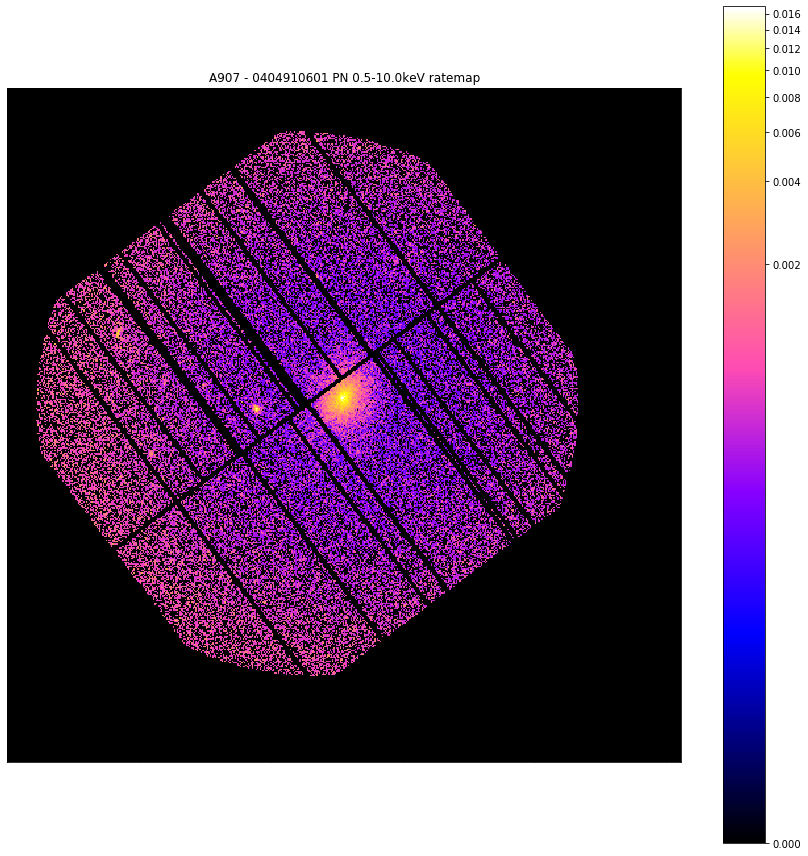

In [29]:
chosen_ratemap.view(figsize=(12, 12))

## Combined images and exposure maps

Now that we have generated images and exposure maps for all the ObsIDs and instruments associated with all these sources that we're interested in analysing, we will want to bring all that information together by creating combined images and exposure maps. Most XGA analyses take place on combined products, because that ability to find all relevant data for a particular source is one of XGA's key strengths. Currently I use the SAS routine emosaic to generate the combined data products, and it is nearly as simple as generating images and exposure maps, the main difference is that you need to tell emosaic what type of product you want to combine:

In [14]:
# ------------IMAGES------------
# Starting off with making combined images for the sample
demo_smp = emosaic(demo_smp, 'image', lo_en=lo_en, hi_en=hi_en)

# And for the single source
demo_src = emosaic(demo_src, 'image', lo_en=lo_en, hi_en=hi_en)

# -----------EXPMAPS------------
# The same again but telling emosaic that we want combined exposure maps this time
demo_smp = emosaic(demo_smp, 'expmap', lo_en=lo_en, hi_en=hi_en)

demo_src = emosaic(demo_src, 'expmap', lo_en=lo_en, hi_en=hi_en)

## Bulk generation of photometric products